# RETO MINSAIT
Participantes:

* Juan Luis Ruiz-Tagle
* Jorge Martín
* Mateusz Klimas

Centro: Universidad Politécnica de Madrid

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import *

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss


Using TensorFlow backend.


## Importamos los datos

In [2]:
estimate = pd.read_csv("csv/Estimar_UH2020.txt", sep = "|")
data = pd.read_csv("csv/Modelar_UH2020.txt", sep = "|")
total = pd.concat([data,estimate])

C:\Users\jmlga\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


## Comprobamos cual es la distribución por clases

<BarContainer object of 7 artists>

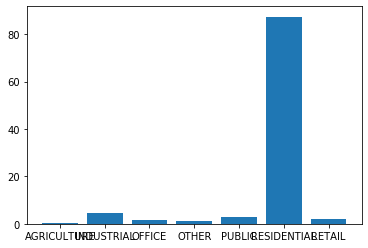

In [3]:
# Distribucion de las clases en los datos
d = total[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, class_percentage["X"])

## Dividimos los datos en train and validation

In [4]:
# Decidimos dejar un 10% de los datos para el test.
train, test = train_test_split(data, test_size=0.1, random_state=1, stratify=data.CLASE)

Comprobamos la distribución de las clases en el training set

<BarContainer object of 7 artists>

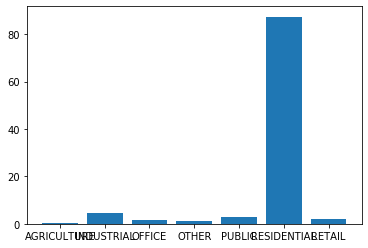

In [5]:
# Distribucion de las clases en el trainig set
d = train[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, class_percentage["X"])

In [6]:
d

,X
CLASE,
AGRICULTURE,304
INDUSTRIAL,4041
OFFICE,1645
OTHER,1199
PUBLIC,2678
RESIDENTIAL,81156
RETAIL,1884


Comprobamos la distribución de las clases en el test set

<BarContainer object of 7 artists>

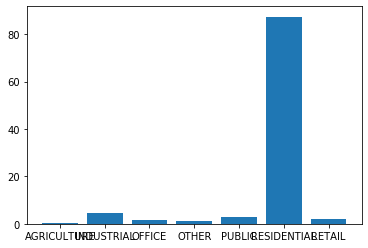

In [7]:
# Distribucion de las clases en el test set
d = test[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, class_percentage["X"])

Balanceamos el test aleatoriamente para no tener tantas instancias de la clase RESIDENTIAL

In [8]:
from sklearn.utils import shuffle

test_residential = test[test["CLASE"] == "RESIDENTIAL"]
test_residential = shuffle(test_residential)
test_residential = test_residential[1:800]


test_balanced = test[test["CLASE"] != "RESIDENTIAL"]
test_balanced = test_balanced.append(test_residential)

<BarContainer object of 7 artists>

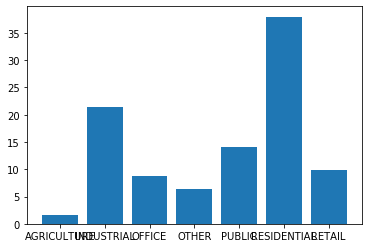

In [9]:
# Distribucion de las clases en el test set
d = test_balanced[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, class_percentage["X"])

In [10]:
d

,X
CLASE,
AGRICULTURE,34
INDUSTRIAL,449
OFFICE,183
OTHER,133
PUBLIC,298
RESIDENTIAL,799
RETAIL,209


# Análisis exploratorio

# Clases balanceadas

Consideramos que la cantidad de instancias de cada clase no está balanceada, por lo que aplicaremos técnicas de under-sampling para la clase residential y, una vez hecho esto, utilizaremos over-sampling para el resto de las clases.


### Under-Sampling: Near Miss algorithm

**NearMiss** is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process. There are three versions, and we selected the third one:

* **_Version 1_** : It selects samples of the majority class for which average distances to the k closest instances of the minority class is smallest.

* **_Version 2_** : It selects samples of the majority class for which average distances to the k farthest instances of the minority class is smallest.

* **_Version 3_** : It works in 2 steps. Firstly, for each minority class instance, their 5 nearest-neighbors will be stored. Then finally, the majority class instances are selected for which the average distance to the N nearest-neighbors is the largest.

Más información: 
    
* [Documentación de la API](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NearMiss.html)
* [Guía para implementarlo](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/)

In [11]:
# Pre-procesamos los datos
processed_data = process_data(train)

# Dropping the ID column
processed_data = processed_data.drop(columns=["ID"])

# The features are selected for the x_train while the class residential is selected as the output
x_train = processed_data.drop(columns=['CLASE', 'AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC', 'RESIDENTIAL', 'RETAIL'])
y_train = processed_data.loc[:, ['RESIDENTIAL']]
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 

# Version 3 of the algorithm is selected
nr = NearMiss({1: 16000}, version = 3)

# Fitting the model would return the undersampled data.
X_train_miss, y_train_miss = nr.fit_sample(x_train, y_train.ravel()) 

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0))) 

Before Undersampling, counts of label '1': [81156]
Before Undersampling, counts of label '0': [11732] 

After Undersampling, the shape of train_X: (27732, 54)
After Undersampling, the shape of train_y: (27732,) 

After Undersampling, counts of label '1': 16000
After Undersampling, counts of label '0': 11732


Una vez hemos hecho el under-sampling, le damos la estructura original que tenían los datos.

In [12]:
resulting_data = pd.DataFrame(X_train_miss)

resulting_data["CLASE"] = "RESIDENTIAL"
resulting_data["AGRICULTURE"], resulting_data["INDUSTRIAL"], resulting_data["OFFICE"], resulting_data["OTHER"], resulting_data["PUBLIC"]  = 0.0, 0.0, 0.0, 0.0, 0.0
resulting_data["RESIDENTIAL"] = y_train_miss
resulting_data["RETAIL"] = 0.0

resulting_data.columns = processed_data.columns

resulting_residential_data = resulting_data[resulting_data["RESIDENTIAL"] == 1]
resulting_residential_data.shape

(16000, 62)

Puede verse a continuación cómo se ha reducido el número de instancias de la clase residential.

<BarContainer object of 7 artists>

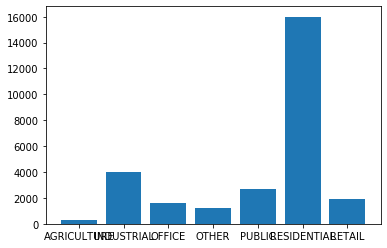

In [13]:
balanced_data = processed_data[processed_data.RESIDENTIAL != 1].append(resulting_residential_data)

# Distribucion de las clases en los datos
d = balanced_data[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, d.X)

In [14]:
d

,X
CLASE,
AGRICULTURE,290
INDUSTRIAL,4037
OFFICE,1645
OTHER,1199
PUBLIC,2678
RESIDENTIAL,16000
RETAIL,1883


### Over-Sampling: Synthetic Minority Oversampling Technique (SMOTE)

**SMOTE** synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

Más información: 
    
* [Documentación de la API](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)
* [Guía para implementarlo](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/)


Procesamos de nuevo los datos para que puedan usarse en el modelo

In [15]:
x_train_smote = balanced_data.drop(columns=['CLASE', 'AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC', 'RESIDENTIAL', 'RETAIL'])
y_train_smote = balanced_data.loc[:, ['CLASE']]

# Reemplazar por números, el algoritmos SMOTE no puede lidiar con clases de tipo string
replacement  = {"AGRICULTURE" : 1, 
                "INDUSTRIAL" : 2, 
                "OFFICE" : 3, 
                "OTHER" : 4,
                "PUBLIC" : 5,
                "RESIDENTIAL" : 6, 
                "RETAIL" : 7}

y_train_smote.CLASE =  y_train_smote.CLASE.replace(replacement)

Aplicamos el algoritmo, cómo no queremos generar muchas instancias de clases como AGRICULTURE, decidimos crear instancias de una manera controlada. Según las clases, los aumentos son:

* **Agriculture**: hasta 3000
* **Industrial**:  hasta 8000
* **Office**:      hasta 6000
* **Other**:       hasta 6000
* **Public**:      hasta 6000
* **Retail**:      hasta 6000

In [16]:
print('Number values X: ' + str(len(x_train_smote)))
print('Number values y: ' + str(len(y_train_smote)))

oversample = SMOTE({1 : 3000,
                    2 : 8000,
                    3 : 6000,
                    4 : 6000,
                    5 : 6000,
                    7 : 6000},
                   random_state=42)

x_train_smote, y_train_smote = oversample.fit_resample(x_train_smote, y_train_smote)

print('Number values X after SMOTE: ' + str(len(x_train_smote)))
print('Number values y after SMOTE: ' + str(len(y_train_smote)))

Number values X: 27732
Number values y: 27732
Number values X after SMOTE: 51000
Number values y after SMOTE: 51000


Una vez hemos hecho el over-sampling, le damos la estructura original que tenían los datos.

In [17]:
y_train_smote.head()
replacement  = {1 : "AGRICULTURE", 
                2 : "INDUSTRIAL", 
                3 : "OFFICE", 
                4 : "OTHER",
                5 : "PUBLIC",
                6 : "RESIDENTIAL", 
                7 : "RETAIL"}

y_train_smote.CLASE =  y_train_smote.CLASE.replace(replacement)

#One hot encode CLASE
enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
df_cls = y_train_smote.CLASE.values.reshape(-1, 1)
df_cls_encoded = pd.DataFrame(enc.fit_transform(df_cls), columns = enc.categories_[0])
df_cls_encoded.index = y_train_smote.index

#Append and concatenate
labels_processed = pd.merge(y_train_smote, df_cls_encoded, left_index=True, right_index=True)

balance_data = x_train_smote
balance_data["CLASE"] = labels_processed["CLASE"]
balance_data["AGRICULTURE"] = labels_processed["AGRICULTURE"]
balance_data["INDUSTRIAL"] = labels_processed["INDUSTRIAL"] 
balance_data["OFFICE"] = labels_processed["OFFICE"] 
balance_data["OTHER"] = labels_processed["OTHER"]
balance_data["PUBLIC"] = labels_processed["PUBLIC"]
balance_data["RESIDENTIAL"] = labels_processed["RESIDENTIAL"] 
balance_data["RETAIL"] = labels_processed["RETAIL"]

balance_data.columns = processed_data.columns

Puede verse a continuación cómo se han aumentado el número de instancias de las diferentes clases.

<BarContainer object of 7 artists>

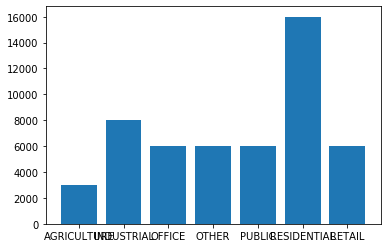

In [18]:
# Distribucion de las clases en los datos
d = balance_data[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, d.X)

# Correlation matrix
Para ver las relaciones existentes entre las variables, primero las estandarizamos y luego mostramos la matriz de correlación.
Esta estandarización no se aplica a cada variable por separado, sino a grupos de variables, en concreto:
* El grupo de deciles de los 4 canales,
* Las coordenadas X e Y
* La variables de geometría del terreno
* El resto de variables se estandarizan individualmente

Esto se hace para no perder información entre las proporciones de unas variables y otras.
También se crea una escala ordinal para la variable catastral_quality.

Para ver la correlación entre las clases primero se aplica OneHotEncoding a las clases, creando 7 nuevas columnas. Estas columnas se convierten en la variable a predecir
Todo esto se hace en la función ``process_data()``


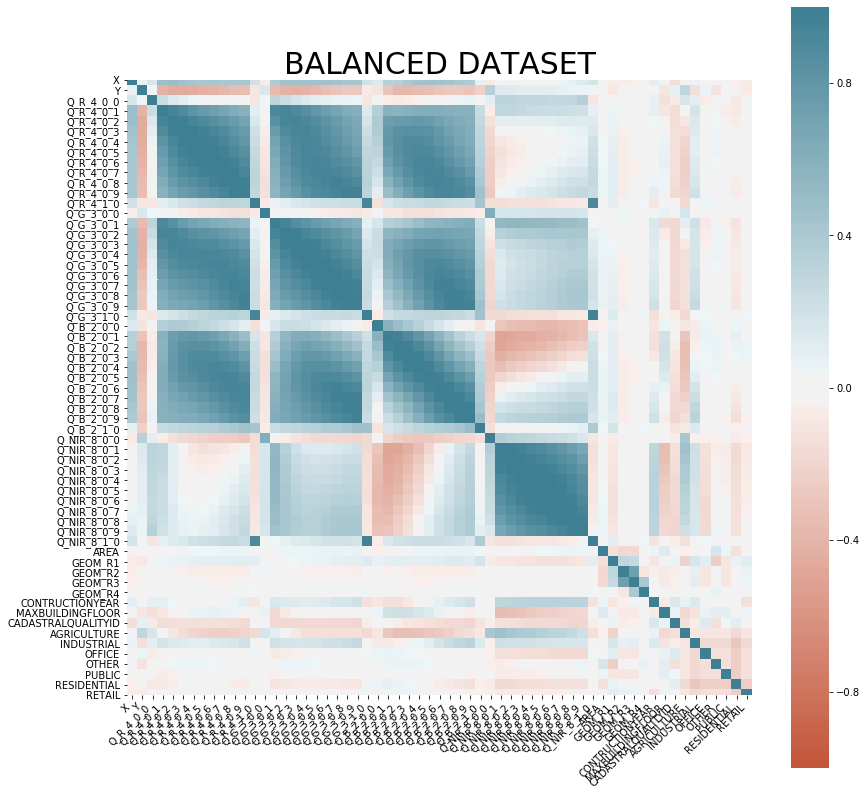

In [19]:
balanced_data_std = balance_data
plot_corr(balanced_data_std, "BALANCED DATASET")

En el mapa de correlación anterior, se puede apreciar como las colas de los canales de color (deciles 0 y 10) no aportan ningún tipo de información. Lo comprobaremos más adelante.
También se aprecia cierta correlación inversa entre los primeros deciles del canal NIR y el azul

# Canales RGB y NIR
A continuación se muestran las medias de cada decil para cada canal en cada tipo de terreno.
Vemos cómo la distribución de colores es muy distinta en muchos de estos casos. En cambio, vemos como los deciles 0 y 10 prácticamente siempre tienden al 0

C:\Users\jmlga\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


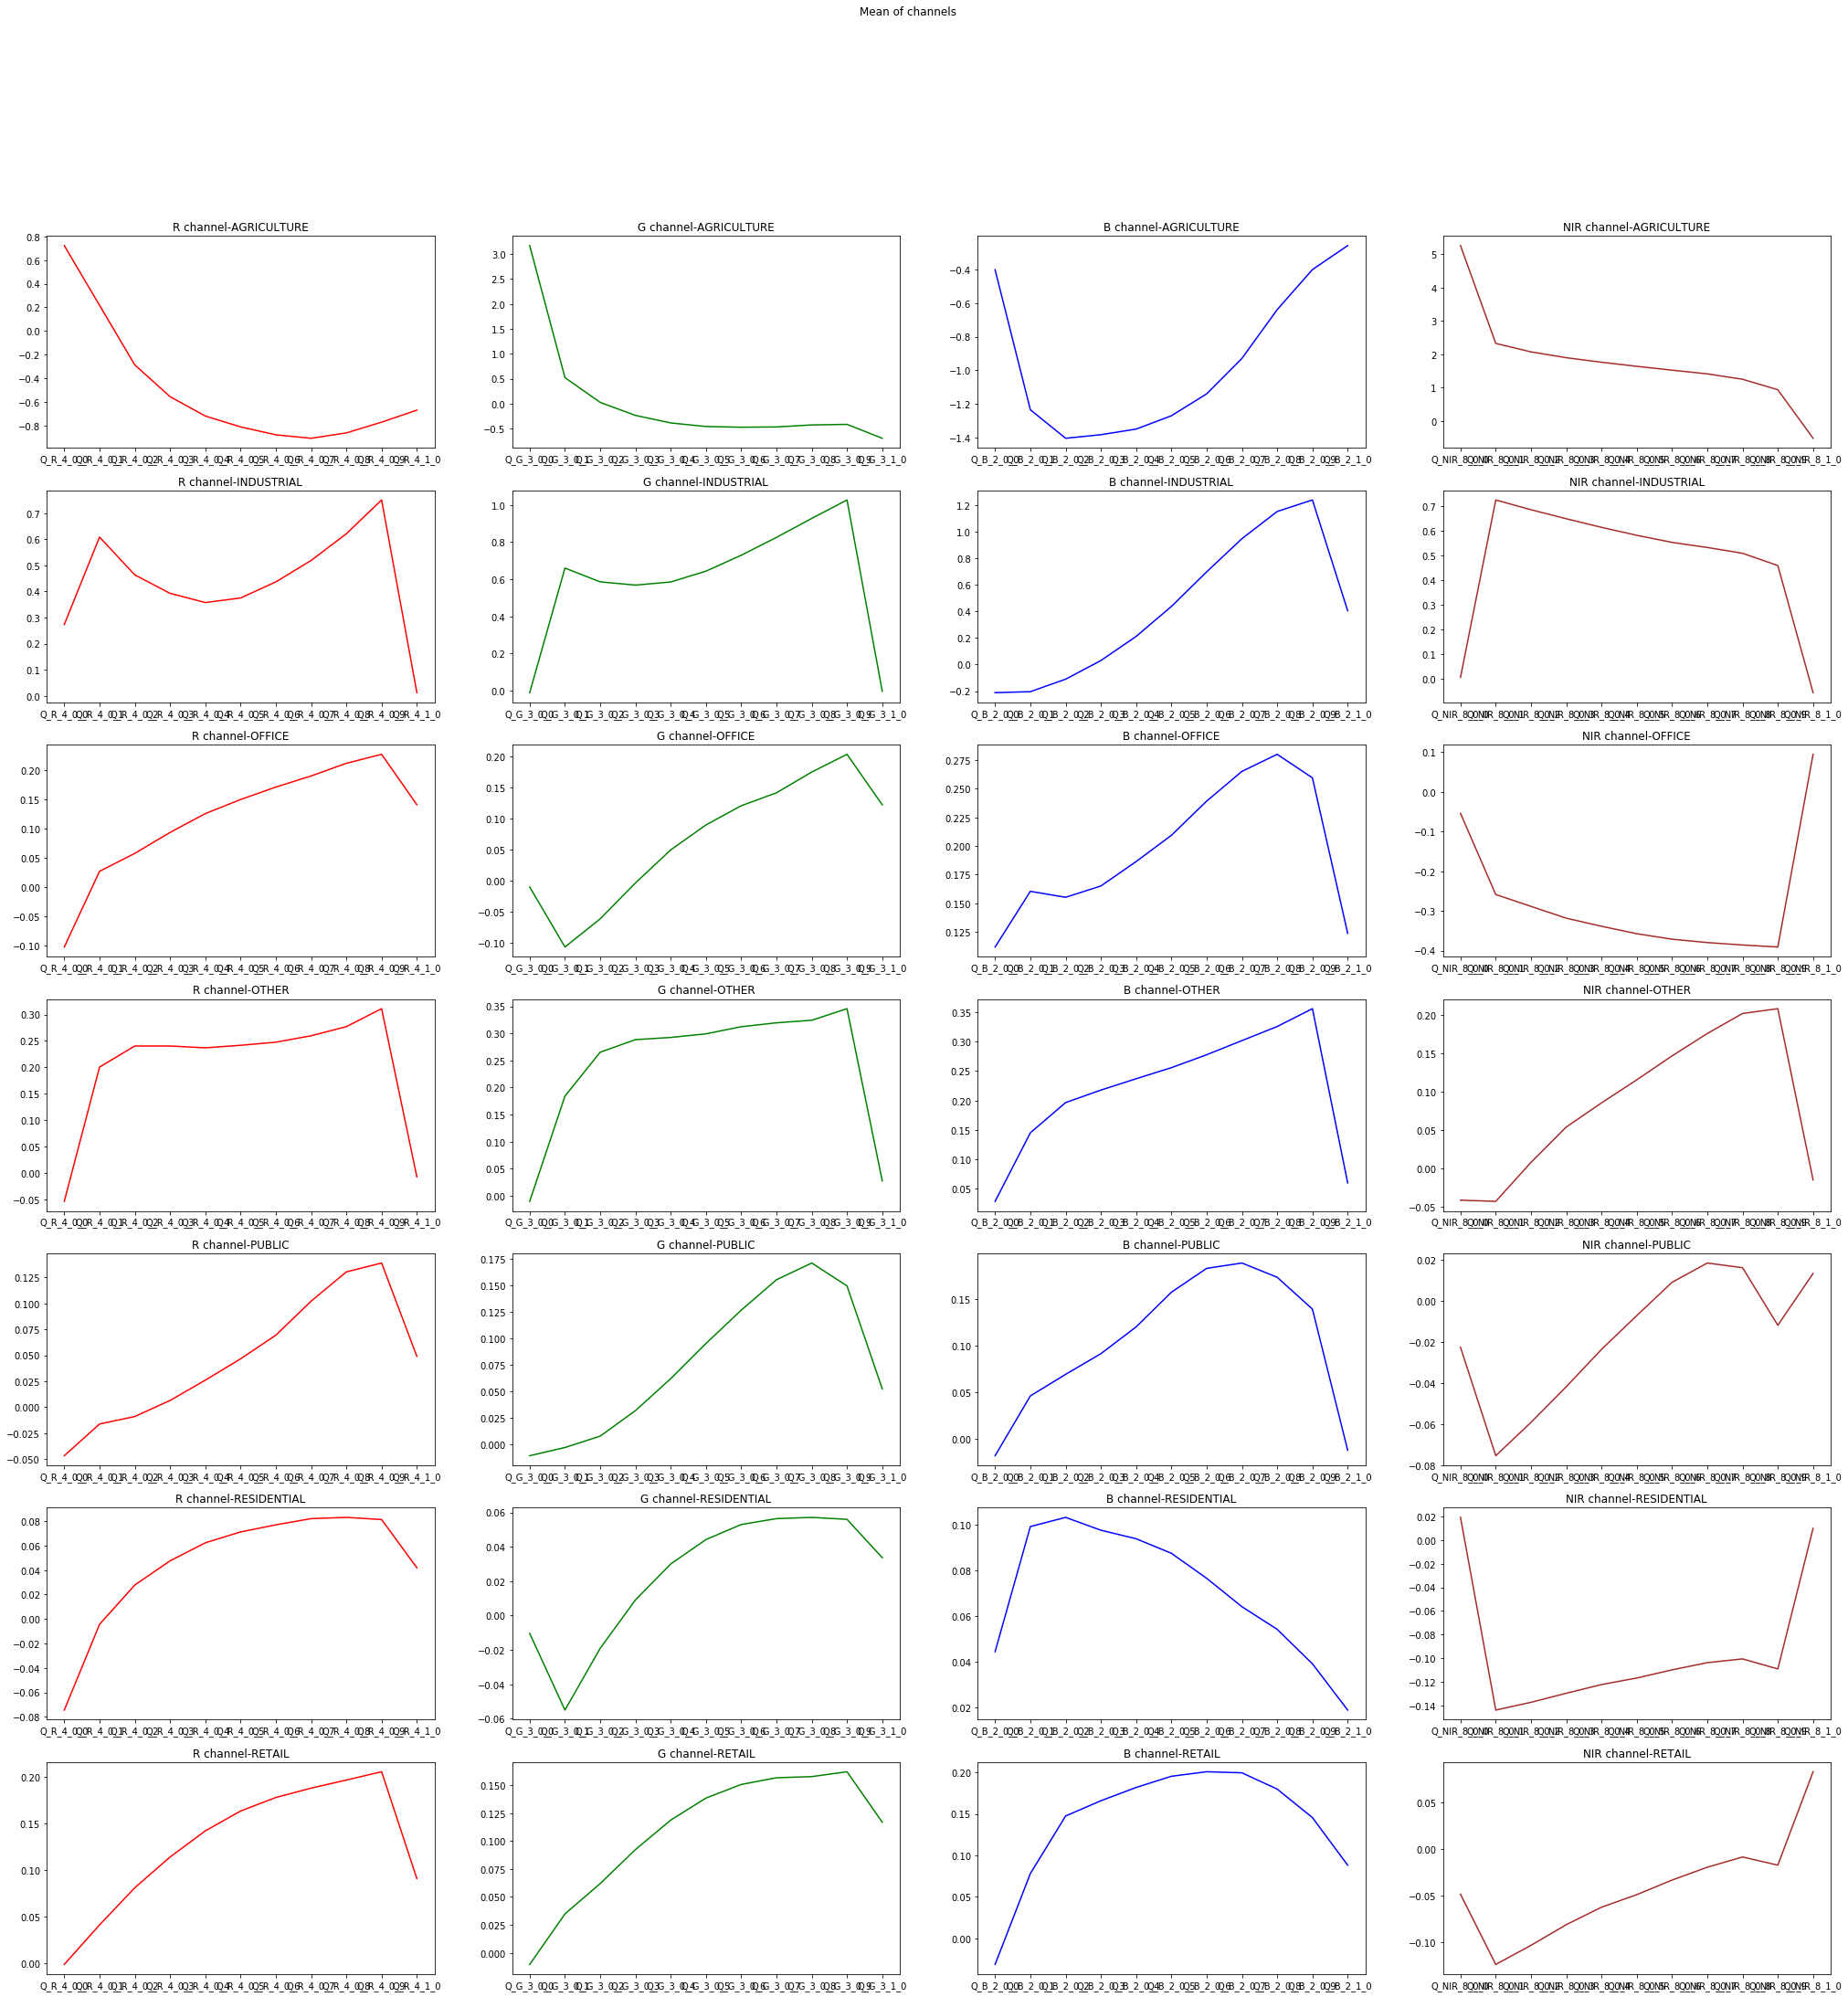

In [20]:
rgbnir_cols = balanced_data_std.columns.str.contains("Q_")
group = balanced_data_std.iloc[:,rgbnir_cols]
group["CLASE"] = balanced_data_std["CLASE"]
class_mean = group.groupby("CLASE").mean()
plot_all_channels(class_mean)

# Neural model
Vemos como las distribuciones tienen formas muy particulares. Las colas de cada distribución se tienen que descartar. 
Está claro que el orden de los deciles tiene que preservarse de alguna manera, y no podemos pasar las variables de forma individual. En un primer intento intentamos codificar estas distribuciones con polinomios de segundo grado, pero no funcionó muy bien.

En el siguiente intento, decidimos crear una red compuesta que tratara por un lado los datos de los canales de color con una CNN de 1 dimension, y por otro una red Densa que aprendiera del resto de datos. Estas dos redes se combinan al final.
En el entrenamiento dejamos de incluir las variables ``MAXBUILDINGFLOOR`` y ``CADASTRALQUALITYID`` pues bloqueaban el entrenamiento

In [21]:
balanced_data_std.columns

Index(['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3',
       'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8',
       'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2',
       'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7',
       'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
       'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6',
       'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0',
       'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4',
       'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8',
       'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'CLASE', 'AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC',
       'RESIDENTIAL', 'RETAIL'],
      dtype='object')

## Preparamos los datos para entrenar el modelo

In [22]:
data_dense, data_rgbnir, labels = prepare_data_for_network(balanced_data_std, process_data_bool = False)
test_data_dense, test_data_rgbnir, test_labels = prepare_data_for_network(test_balanced, process_data_bool = True)

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Concatenate, Input, concatenate, BatchNormalization
from keras.layers import Embedding, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.metrics import *
from keras.initializers import glorot_normal


def merged_net():
    
    dropout_rate = 0.2
    
    #DENSE net
    dense_input = Input(shape=(10,), name='main_input')
    dense = Dense(250, activation='relu')(dense_input)
    dense = Dropout(dropout_rate)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(200, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = BatchNormalization()(dense)
    dense= Dense(100, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(100, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense_out = BatchNormalization()(dense)
    
    #CNN1D
    seq_length = 11
    kernel = 2
    
    cnn_input = Input(shape=(seq_length,4), name='cnn_input')
    cnn = Conv1D(32, kernel_size= kernel, activation='relu')(cnn_input)
    cnn = Conv1D(64, kernel_size= kernel, activation='relu')(cnn)
    cnn = Conv1D(64, kernel_size= kernel, activation='relu')(cnn)
    cnn = Conv1D(128, kernel_size= kernel, activation='relu')(cnn)
    cnn = Flatten()(cnn)
    cnn_out = Dropout(dropout_rate)(cnn)
    

    #MERGED net
    concat = concatenate([cnn_out, dense_out])
    concat = Dense(50, activation='relu')(concat)
    model_output = Dense(7, activation='sigmoid')(concat)
    
    model = Model(inputs=[cnn_input, dense_input], outputs=[model_output])

    model.compile(loss='categorical_crossentropy',
                  optimizer= "nadam" ,
                  metrics=["accuracy"])
    return model

## Creamos el modelo y lo entrenamos 20 epochs

In [24]:
model = merged_net()

In [26]:
history = model.fit([data_rgbnir, data_dense], labels, batch_size = 100, epochs = 20)

Epoch 1/20
51000/51000 [==============================] - 11s 212us/step - loss: 1.1910 - accuracy: 0.5548
Epoch 2/20
51000/51000 [==============================] - 11s 218us/step - loss: 1.1606 - accuracy: 0.5638
Epoch 3/20
51000/51000 [==============================] - 11s 216us/step - loss: 1.1398 - accuracy: 0.5721
Epoch 4/20
51000/51000 [==============================] - 11s 211us/step - loss: 1.1187 - accuracy: 0.5786
Epoch 5/20
51000/51000 [==============================] - 12s 237us/step - loss: 1.1008 - accuracy: 0.5846
Epoch 6/20
51000/51000 [==============================] - 12s 227us/step - loss: 1.0849 - accuracy: 0.5909
Epoch 7/20
51000/51000 [==============================] - 13s 258us/step - loss: 1.0740 - accuracy: 0.5930
Epoch 8/20
51000/51000 [==============================] - 13s 256us/step - loss: 1.0610 - accuracy: 0.5975s - loss: 1.0 - ETA: 0s - loss: 1.0
Epoch 9/20
51000/51000 [==============================] - 11s 223us/step - loss: 1.0521 - accuracy: 0.5996
Ep

In [27]:
# Evaluate and plot the model
def evaluate_and_plot(model, history):
    score = model.evaluate([test_data_rgbnir, test_data_dense],test_labels)
    print("loss=" + str(score[0]) + " accuracy=" + str(score[1]))
    plt.plot(history.history['accuracy'])

2104/2104 [==============================] - 0s 75us/step
loss=1.3454963594335114 accuracy=0.552281379699707


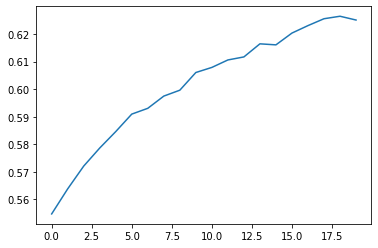

In [28]:
evaluate_and_plot(model, history)

La **matriz de confusión** nos permitirá saber cómo se comporta el modelo creado para cada clase, dando así información sobre qué clases son más difíciles de predecir, o entre cuáles hay cierta confusión.

In [29]:
predictions = model.predict([test_data_rgbnir, test_data_dense])
confusion_matrix_dataframe(predictions, test_labels)

,AGRICULTURE,INDUSTRIAL,OFFICE,OTHER,PUBLIC,RESIDENTIAL,RETAIL
AGRICULTURE,21,3,0,0,2,7,0
INDUSTRIAL,8,181,24,13,3,211,9
OFFICE,1,17,36,10,6,109,4
OTHER,0,1,4,65,6,49,8
PUBLIC,2,11,18,46,55,152,14
RESIDENTIAL,0,2,1,4,6,778,8
RETAIL,1,7,9,9,7,150,26


In [30]:
matrix = confusion_matrix_dataframe(predictions, test_labels)

In [31]:
aciertos = 0
total = 0

for i in matrix.index:
    for j in matrix.columns:
        if i == j:
            aciertos = aciertos + matrix[i][j]
            total = total + matrix[i][j]
        else: 
            total = total + matrix[i][j]
print("Accuracy: " + str((aciertos/total*100).round(2)) + "%")

Accuracy: 55.23%


### Predecimos con el modelo y exportamos los datos

In [32]:
final_test_dense, final_test_rgbnir = prepare_data_for_network(estimate, is_final_test = True)

In [33]:
predictions = model.predict([final_test_rgbnir, final_test_dense])
dictionary = {i: terreno for i , terreno in zip(range(7), ['AGRICULTURE', 
                                                           'INDUSTRIAL', 
                                                           'OFFICE', 
                                                           'OTHER', 
                                                           'PUBLIC',
                                                           'RESIDENTIAL', 
                                                           'RETAIL'])}
results = []
for p in predictions:
    pos = np.argmax(p)
    results.append(dictionary.get(pos))
final_result = pd.concat([estimate["ID"],pd.DataFrame(results)], axis = 1)
final_result.columns = ["ID","CLASE"]

In [34]:
def generate_output(df, name = "UPM_bestermans.txt"):
    df.columns =   ["ID","CLASE"]
    df.to_csv(name, sep = "|", index = False)

In [35]:
generate_output(final_result)